In [1]:
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import torch
from torchvision import transforms

In [4]:
DATA_DIR = '../data/train'
CSV_PATH = '../data/train_labels.csv'

In [5]:
df = pd.read_csv(CSV_PATH)
print("Total rows:", len(df))
print("Datasets:", df['dataset'].nunique())
df.head()

Total rows: 1945
Datasets: 13


,dataset,scene,image,rotation_matrix,translation_vector
0,imc2023_haiper,fountain,fountain_image_116.png,0.122655949;0.947713775;-0.294608417;0.1226706...,0.093771314;-0.803560988;2.062001533
1,imc2023_haiper,fountain,fountain_image_108.png,0.474305910;0.359108654;-0.803787832;0.2888416...,0.358946647;-0.797557548;1.910906929
2,imc2023_haiper,fountain,fountain_image_101.png,0.565115476;-0.138485064;-0.813305838;0.506678...,0.146922468;-0.981392596;2.009002852
3,imc2023_haiper,fountain,fountain_image_082.png,-0.308320392;-0.794654112;0.522937261;0.948141...,0.206413831;-1.174321103;3.667167680
4,imc2023_haiper,fountain,fountain_image_071.png,-0.569002830;-0.103808175;0.815757098;0.778745...,-0.015140892;-1.334052012;3.488936597


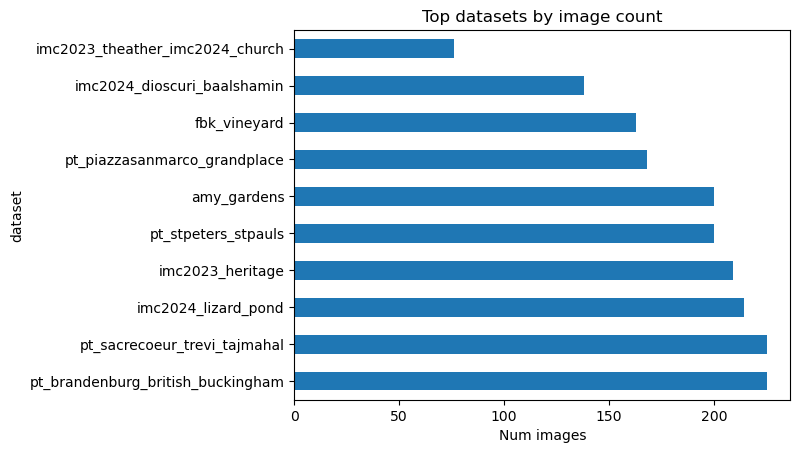

In [6]:
df['dataset'].value_counts().head(10).plot(kind='barh')
plt.title("Top datasets by image count")
plt.xlabel("Num images")
plt.show()

In [7]:
def pad_to_square(image: Image.Image, fill=0):
    w, h = image.size
    max_side = max(w, h)
    left = (max_side - w) // 2
    top = (max_side - h) // 2
    right = max_side - w - left
    bottom = max_side - h - top
    return F.pad(image, (left, top, right, bottom), fill=fill)

In [8]:
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.Lambda(pad_to_square),
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

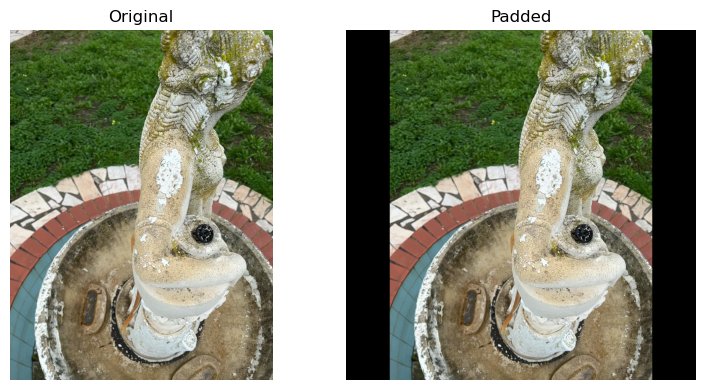

In [9]:
sample = df.iloc[0]
img_path = os.path.join(DATA_DIR, sample['dataset'], sample['image'])
img = Image.open(img_path).convert('RGB')

padded = pad_to_square(img)
processed = transform(img)

# Visualize original and padded
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(img)
axs[0].set_title("Original")
axs[1].imshow(padded)
axs[1].set_title("Padded")
for ax in axs: ax.axis('off')
plt.tight_layout()
plt.show()

In [10]:
def load_batch(df_subset, root_dir, transform):
    tensors = []
    for _, row in df_subset.iterrows():
        path = os.path.join(root_dir, row['dataset'], row['image'])
        image = Image.open(path).convert('RGB')
        tensor = transform(image)
        tensors.append(tensor)
    return torch.stack(tensors)